In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from prettytable import PrettyTable
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
data_path = '/home/monodeepdas112/Datasets/amazon-fine-food-reviews/database.sqlite'
con = sqlite3.connect(data_path)

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [10]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [11]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [13]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [14]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [15]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:17<00:00, 2527.79it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [18]:
# ## Similartly you can do preprocessing for review summary also.
# # Combining all the above stundents 
# from tqdm import tqdm
# preprocessed_review_summarys = []
# # tqdm is for printing the status bar
# for sentance in tqdm(final['Summary'].values):
#     sentance = re.sub(r"http\S+", "", sentance)
#     sentance = BeautifulSoup(sentance, 'lxml').get_text()
#     sentance = decontracted(sentance)
#     sentance = re.sub("\S*\d\S*", "", sentance).strip()
#     sentance = re.sub('[^A-Za-z]+', ' ', sentance)
#     # https://gist.github.com/sebleier/554280
#     sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
#     preprocessed_review_summarys.append(sentance.strip())

# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

In [19]:
#Getting the necessary imports and function definations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import pprint
from sklearn.pipeline import Pipeline
import os.path
import pickle

### [5.0.0] Splitting up the Dataset into D_train and D_test

In [20]:
prettytable_data = []

In [21]:
Dx_train, Dx_test, Dy_train, Dy_test = train_test_split(preprocessed_reviews[:25000], final['Score'].tolist()[:25000], test_size=0.20, random_state=42)

### [5.0.1] Training Global W2V Model

In [22]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentences=[]
for sentence in tqdm(preprocessed_reviews):
    list_of_sentences.append(sentence.split())
w2v_model=Word2Vec(list_of_sentences, min_count=5,size=100, workers=3)

100%|██████████| 348260/348260 [00:02<00:00, 136855.40it/s]


### [5.0.1] Defining some functions to increase code reusability and readability

In [23]:
'''Creating Custom Vectorizers for TFIDF - W2Vec and Avg - W2Vec'''
class Tfidf_W2Vec_Vectorizer(object):
    def __init__(self, W2V_model):
        self.tfidf = TfidfVectorizer(max_features=100)
        self.word2vec = W2V_model
        self.dictionary = None
        self.tfidf_feat = None
        self.w2vec_words = list(self.word2vec.wv.vocab)
#         self.w2vec_words = None
        
    def fit(self, X):
        #Initializing the TFIDF Vectorizer
        self.tfidf.fit_transform(X)
        
#         #Initializing the Word2Vec Model
#         list_of_sentences=[]
#         for sentence in X:
#             list_of_sentences.append(sentence.split())
#         self.word2vec=Word2Vec(list_of_sentences, min_count=5, size=1000, workers=4)
        
        # we are converting a dictionary with word as a key, and the idf as a value
#         self.w2vec_words = list(self.word2vec.wv.vocab)
        self.dictionary = dict(zip(self.tfidf.get_feature_names(), list(self.tfidf.idf_)))
#         self.w2vec_words = list(self.word2vec.wv.vocab)
        self.tfidf_feat = self.tfidf.get_feature_names()
        return self

    def transform(self, x):
        vectors = []
        for X in x:
            vectors.append(np.array([
                    np.mean([self.word2vec[w] * self.dictionary[word]*(X.cout(word)/len(X))
                             for w in words if w in self.word2vec and w in self.tfidf_feat] or
                            [np.zeros(100)], axis=0)
                    for words in X
                ]))
        return np.array(vectors)

class Avg_W2Vec_Vectorizer(object):
    def __init__(self, W2V_model):
        self.word2vec = W2V_model

    def fit(self, X):
#         list_of_sentences=[]
#         for sentence in X:
#             list_of_sentences.append(sentence.split())
#         self.word2vec = Word2Vec(list_of_sentences, min_count=5, size=50, workers=4)
        return self

    def transform(self, x):
        vectors = []
        for X in x:
            vectors.append(np.array([
                np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                        or [np.zeros(100)], axis=0)
                for words in X
            ]))
        return np.array(vectors)

In [24]:
'''Creation of Pipeline'''    
def get_vectorizer(vectorizer, train, W2V_model):
    if(vectorizer=='BOW'):
        vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
    if(vectorizer=='TFIDF'):
        vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
    if(vectorizer=='TFIDF-W2Vec'):
        vectorizer = Tfidf_W2Vec_Vectorizer(W2V_model)
    if(vectorizer=='Avg-W2Vec'):
        vectorizer = Avg_W2Vec_Vectorizer(W2V_model)
    
    vectorizer.fit(train)
    return vectorizer

In [25]:
def perform_hyperparameter_tuning(X, Y, algorithm, vectorizer, vec_name, W2V_model=None):
    #If the pandas dataframe with the hyperparameter info exists then return it
    results_name = 'saved_models/{0}_knn_results.csv'.format(vec_name)
    if(os.path.exists(results_name)):
        return pd.read_csv(results_name)
    
    #else perform hyperparameter tuning
    parameters_grid = {
        'knn__weights' : ['uniform','distance'],
        'knn__algorithm' : [algorithm],
        'knn__n_neighbors' : [5, 9, 13, 17, 23, 29, 31, 35, 37, 41, 47, 53, 71]
    }

    weight_scheme = []
    n_neigh = []
    algo_used = []
    train_scores = []
    test_scores = []

    train_mean_score = []
    test_mean_score = []

    # Initializing KFold
    skf = StratifiedKFold(n_splits=10)
    X = np.array(X)
    Y = np.array(Y)

    for weight in parameters_grid['knn__weights']:
        for k in tqdm(parameters_grid['knn__n_neighbors']):
            for algo in parameters_grid['knn__algorithm']:

                #Performing Cross Validation
                for train_index, test_index in skf.split(X, Y):
                    Dx_train, Dx_cv = X[train_index], X[test_index]
                    Dy_train, Dy_cv = Y[train_index], Y[test_index]

                    #Initializing the Vectorizer
                    vectorizer = get_vectorizer(vectorizer, Dx_train.tolist(), W2V_model)
                    

                    #Transforming the data to features
                    x_train = vectorizer.transform(Dx_train.tolist())
                    x_cv = vectorizer.transform(Dx_cv.tolist())

                    #Initializing the KNN model
                    knn = KNeighborsClassifier(algorithm=algo, weights=weight, n_neighbors=k)

                    #Training the model
                    knn.fit(x_train, Dy_train)

                    #Prediction
                    train_results = knn.predict_proba(x_train)
                    cv_results = knn.predict_proba(x_cv)

                    try:
                        train_score = roc_auc_score(Dy_train, train_results[:, 1])
                        test_score = roc_auc_score(Dy_cv, cv_results[:, 1])

                        #storing the results to form a dataframe
                        train_scores.append(train_score)
                        test_scores.append(test_score)

                    except Exception as e:
                        print('Error Case : ', e)
                        print(('Actual, Predicted'))
                        [print((Dy_cv[i], cv_results[i, 1])) for i in range(len(Dy_cv))]

                train_mean_score.append(sum(train_scores)/len(train_scores))
                test_mean_score.append(sum(test_scores)/len(test_scores))
                n_neigh.append(k)
                algo_used.append(algo)
                weight_scheme.append(weight)

                print('k={0}, weight={1}, algo={2}, train_score={3}, test_score={4}'
                      .format(k, weight, algo, sum(train_scores)/len(train_scores), sum(test_scores)/len(test_scores)))

                train_scores = []
                test_scores = []
            
    results_df = pd.DataFrame({'n_neighbours' : n_neigh, 'weight_scheme' : weight_scheme, 
                               'algorithm' : algo_used, 'train_score' : train_mean_score, 
                               'test_score': test_mean_score})
    #writing the results to csv after performing hyperparameter tuning
    results_df.to_csv(results_name)
    return results_df

In [26]:
def analyse_results(df):
    # Sorting the dataframe by the number of neighbours
    df = df.sort_values(by=['n_neighbours', 'test_score'], ascending=[True, False])
    
    #seperating the dataframe by the weighing method to maintain uniformity of comparisions
    uniform_weighted = df[df['weight_scheme']=='uniform']
    distance_weighted = df[df['weight_scheme']=='distance']
    
    #plotting the uniform weighted measure K-NN results
    fig = plt.figure()
    ax = fig.gca()
    plt.plot(uniform_weighted.n_neighbours, uniform_weighted.test_score, '-o', c='b', label='Validation AUC')
    plt.plot(uniform_weighted.n_neighbours, uniform_weighted.train_score, '-o', c='r', label='Train AUC')
    plt.grid(True)
    plt.xlabel('n-neighbors')
    plt.ylabel('Area Under ROC Curve')
    plt.title('AUC ROC Curve for K-NN with "uniform" distance metrics')
    plt.legend(loc='best')
    plt.show()
    
    #plotting the uniform weighted measure K-NN results
    fig = plt.figure()
    ax = fig.gca()
    plt.plot(distance_weighted.n_neighbours, distance_weighted.test_score, '-o', c='b', label='Validation AUC')
    plt.plot(distance_weighted.n_neighbours, distance_weighted.train_score, '-o', c='r', label='Train AUC')
    plt.grid(True)
    plt.xlabel('n-neighbors')
    plt.ylabel('Area Under ROC Curve')
    plt.title('AUC ROC Curve for K-NN with "inverse-distance" distance metrics')
    plt.legend(loc='best')
    plt.show()

def selecting_best_hyperparameters(df):
    #Selecting the max score and its corresponding characteristics
    tmp = df.sort_values(by=['test_score', 'n_neighbours'], ascending=[False, True])
    #Printing best 5 scores and their params
    print(tmp.iloc[0:15,:].to_string())

In [27]:
def retrain_with_best_hyperparameters(X, Y, best_params_, vectorizer):

    vectorizer = get_vectorizer(vectorizer, X)
    
    x_train = vectorizer.transform(X)
    y_train = np.array(Y)
    
    knn = KNeighborsClassifier(algorithm = best_params_['knn__algorithm'], 
                               n_neighbors = best_params_['knn__n_neighbors'], 
                               weights = best_params_['knn__weights'], 
                               n_jobs=-1)
    #Training the model
    knn.fit(x_train, y_train)
    return knn, vectorizer #returning the vectorizer here so as to avoid having to retrain it again while plotting the AUC curve where D-Train and D_test are same

In [28]:
def plot_confusion_matrix(model, data, labels, dataset_label):
    pred = model.predict(data)
    conf_mat = confusion_matrix(labels, pred)
    
    ax = plt.axes()
    ax.set_title('Confusion Matrix : {0}'.format(dataset_label))
    sns.heatmap(conf_mat, annot=True, fmt="d",cmap="YlGnBu", ax = ax)
    plt.show()

In [29]:
def plot_AUC_ROC(knn, vectorizer, Dx_train, Dx_test, Dy_train, Dy_test):
    
    #predicting probability of Dx_test, Dx_train
    test_score = knn.predict_proba(vectorizer.transform(Dx_test))
    train_score = knn.predict_proba(vectorizer.transform(Dx_train))

    #Finding out the ROC_AUC_SCORE    
    train_roc_auc_score = roc_auc_score(np.array(Dy_train), train_score[:, 1])
    print('Area Under the Curve for Train : ', train_roc_auc_score)
    test_roc_auc_score = roc_auc_score(np.array(Dy_test), test_score[:, 1])
    print('Area Under the Curve for Test : ', test_roc_auc_score)

    #Plotting with matplotlib.pyplot
    #ROC Curve for D-train
    train_fpr, train_tpr, thresholds = roc_curve(np.array(Dy_train), train_score[:, 1])
    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))

    # #ROC Curve for D-test
    test_fpr, test_tpr, thresholds = roc_curve(np.array(Dy_test), test_score[:, 1])
    plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
    
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("Area Under ROC Curve")
    plt.show()
    
    plot_confusion_matrix(knn, vectorizer.transform(Dx_train), np.array(Dy_train), 'Training')
    plot_confusion_matrix(knn, vectorizer.transform(Dx_test), np.array(Dy_test), 'Testing')

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

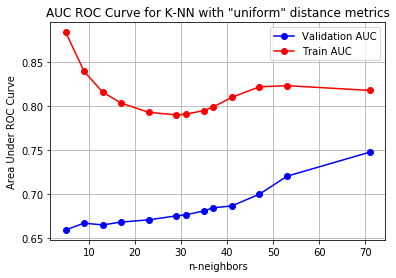

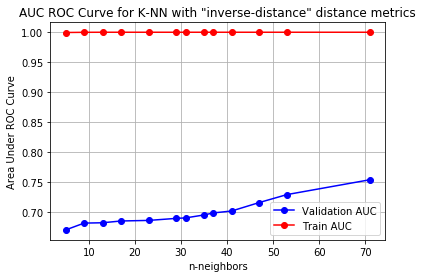

In [30]:
# Please write all the code with proper documentation
results = perform_hyperparameter_tuning(X=Dx_train, Y=Dy_train, algorithm='brute', vectorizer='BOW', vec_name='BagOfWords')
# Analysing results
analyse_results(results)

In [31]:
# selecting_best_hyperparameters(results)
# # As seen from the dataframe {n:23, weight:'distance', algo:brute} seems to be performing reasonably best.
# knn, vectorizer = retrain_with_best_hyperparameters(X=Dx_train, Y=Dy_train, 
#                                         best_params_={'knn__algorithm':'brute', 'knn__n_neighbors':23, 'knn__weights':'distance'}, 
#                                         vectorizer='BOW')
# plot_AUC_ROC(knn, vectorizer, Dx_train, Dx_test, Dy_train, Dy_test)

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

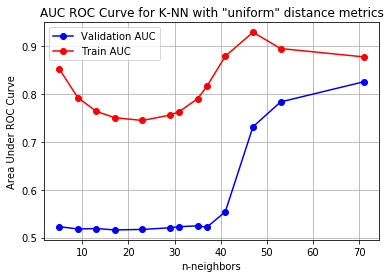

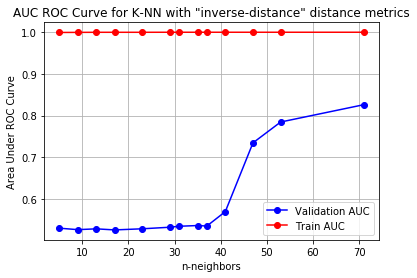

In [32]:
# Please write all the code with proper documentation
results = perform_hyperparameter_tuning(X=Dx_train, Y=Dy_train, algorithm='brute', vectorizer='TFIDF', vec_name='TF-IDF-Vect')
# Analysing results
analyse_results(results)

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [33]:
# Please write all the code with proper documentation
results = perform_hyperparameter_tuning(X=Dx_train, 
                                        Y=Dy_train, algorithm='brute', vectorizer='Avg-W2Vec', 
                                        vec_name='Avg_W2Vec', W2V_model=w2v_model)
# Analysing results
analyse_results(results)

  0%|          | 0/13 [00:00<?, ?it/s]

ValueError: Expected 2D array, got 1D array instead:
array=[array([[ 0.20598961,  0.33309859, -1.04632759, ...,  0.41688371,
         0.25833356, -0.63050693],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.36275667, -0.64197153,  0.38083985, ...,  0.44485345,
         1.61225152,  0.22675802],
       [ 0.67724472, -0.91551393,  0.92801541, ...,  2.65955067,
        -0.01031128, -0.07337163]])
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.0954746 , -0.05695671,  0.22495632, ...,  0.03268363,
         0.99594605,  2.87902689],
       [ 0.36275667, -0.64197153,  0.38083985, ...,  0.44485345,
         1.61225152,  0.22675802],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67724472, -0.91551393,  0.92801541, ...,  2.65955067,
        -0.01031128, -0.07337163],
       [ 0.62308007, -0.20900486, -0.7324577 , ...,  1.40739322,
         1.48355508,  0.42367327]])
 array([[ 1.0954746 , -0.05695671,  0.22495632, ...,  0.03268363,
         0.99594605,  2.87902689],
       [ 0.67724472, -0.91551393,  0.92801541, ...,  2.65955067,
        -0.01031128, -0.07337163],
       [-0.58468539,  0.02132264,  0.65371484, ..., -0.41984901,
         0.26417279,  0.52517438],
       ...,
       [ 0.53442335, -0.50017816, -0.03804145, ...,  0.02278459,
        -0.48906723, -0.49036774],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53442335, -0.50017816, -0.03804145, ...,  0.02278459,
        -0.48906723, -0.49036774]])
 ...
 array([[ 0.39477998,  0.33134937, -0.87662476, ...,  0.58054364,
         1.02431679, -0.66941959],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.59112442,  0.10929315,  0.24359633, ...,  2.19205952,
         0.69907236,  1.01380742],
       ...,
       [ 0.53442335, -0.50017816, -0.03804145, ...,  0.02278459,
        -0.48906723, -0.49036774],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67724472, -0.91551393,  0.92801541, ...,  2.65955067,
        -0.01031128, -0.07337163]])
 array([[ 0.52627188, -0.39698023,  0.04286577, ...,  0.09488035,
         1.15548611, -0.26606607],
       [ 0.59112442,  0.10929315,  0.24359633, ...,  2.19205952,
         0.69907236,  1.01380742],
       [ 0.62308007, -0.20900486, -0.7324577 , ...,  1.40739322,
         1.48355508,  0.42367327],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30718452,  2.25152969, -2.84320188, ..., -2.57698894,
        -2.69977307, -2.30646753],
       [ 0.67724472, -0.91551393,  0.92801541, ...,  2.65955067,
        -0.01031128, -0.07337163]])
 array([[ 0.36275667, -0.64197153,  0.38083985, ...,  0.44485345,
         1.61225152,  0.22675802],
       [ 0.62308007, -0.20900486, -0.7324577 , ...,  1.40739322,
         1.48355508,  0.42367327],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.62308007, -0.20900486, -0.7324577 , ...,  1.40739322,
         1.48355508,  0.42367327],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation
results = perform_hyperparameter_tuning(X=Dx_train, 
                                        Y=Dy_train, 
                                        algorithm='brute', vectorizer='TFIDF-W2Vec', 
                                        vec_name='TFIDF_W2Vec', W2V_model=w2v_model)
# Analysing results
analyse_results(results)

## [5.2] Applying KNN kd-tree

In [ ]:
Dx_train, Dx_test, Dy_train, Dy_test = train_test_split(preprocessed_reviews[:25000], final['Score'].tolist()[:25000], test_size=0.20, random_state=42)

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [ ]:
# Please write all the code with proper documentation
results = perform_hyperparameter_tuning(X=Dx_train, Y=Dy_train, algorithm='kd_tree', vectorizer='BOW', vec_name='BagOfWords_kd')
# Analysing results
analyse_results(results)

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [ ]:
# Please write all the code with proper documentation
results = perform_hyperparameter_tuning(X=Dx_train, Y=Dy_train, algorithm='kd_tree', vectorizer='TFIDF', vec_name='TF_IDF_Vect_kd')
# Analysing results
analyse_results(results)

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
# Please write all the code with proper documentation
results = perform_hyperparameter_tuning(X=Dx_train, Y=Dy_train, algorithm='kd_tree', vectorizer='Avg-W2Vec', vec_name='Avg_W2Vec_kd')
# Analysing results
analyse_results(results)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
# Please write all the code with proper documentation
results = perform_hyperparameter_tuning(X=Dx_train, Y=Dy_train, algorithm='kd_tree', vectorizer='TFIDF-W2Vec', vec_name='TFIDF_W2Vec_kd')
# Analysing results
analyse_results(results)

# [6] Conclusions